In [1]:
# Import packages

# File structure
import os
import pathlib

# Vector data
import geopandas as gpd
import pandas as pd

# Raster data
import rioxarray as rxr
import xarray as xr

# Arrays
import numpy as np

# Maps and plots
import holoviews as hv
import hvplot.pandas
import hvplot.xarray

# Open street map
from osmnx import features as osm
import osmnx as ox

# Earthpy
import earthpy
#import earthpy.api.appeears as eaapp

# Plotting
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression


In [2]:
# Important: If you haven't already, you need to install pygbif using the command below
# Run this command in the terminal to install: pip install pygbif

# Import packages
import os # For file paths, data management, interacting with the operating system
import pathlib # Object oriented file path management
import time # Time how long operations take in Python
import zipfile # Deal with zip files
from getpass import getpass # Security login for downloading GBIF data
from glob import glob # Search for specific file extensions

# Libraries for data analysis 
import pandas as pd # Data analysis for tabular data
import geopandas as gpd # Data analysis for geospatial data
import pygbif.occurrences as occ # Get occurrence data
import pygbif.species as species # Get species data
import requests # Download data

# Libraries for Dynamic mapping
import cartopy.crs as ccrs #Coordinate reference systems 
import panel as pn #customize the dynamic map
import hvplot.pandas #make the holoview plot with geo-dataframe
import calendar # Change month numbers to month names

In [4]:
# Define data directory in user's home directory
data_dir_2024 = os.path.join(
    # Home directory
    pathlib.Path.home(),
    # Earth analytics data directory
    'earth-analytics',
    'data',
    # Project directory
    'redstart-migration-2024',
)
print(data_dir_2024)
# Make the directory using the path defined above
os.makedirs(data_dir_2024, exist_ok=True)

/home/jovyan/earth-analytics/data/redstart-migration-2024


In [5]:
# GBIF LOGIN CODE CHUNK
# Code credit: Elsa Culler
# This code allows us to download data in Python from gbif.org
# This code ASKS for your credentials for gbif.org
# and saves it for the rest of the session.
# NEVER put your credentials into your code

# GBIF needs a username, password, and email 
# All 3 need to match the account
reset = False

# Request and store username
if (not ('GBIF_USER'  in os.environ)) or reset:
    os.environ['GBIF_USER'] = input('GBIF username:')

# Securely request and store password
if (not ('GBIF_PWD'  in os.environ)) or reset:
    os.environ['GBIF_PWD'] = getpass('GBIF password:')
    
# Request and store account email address
if (not ('GBIF_EMAIL'  in os.environ)) or reset:
    os.environ['GBIF_EMAIL'] = input('GBIF email:')

In [6]:
# Search for the Hermit Thrush (Catharus guttatus)
backbone = species.name_backbone(name='Setophaga ruticilla')

# Save the species key
species_key = backbone["speciesKey"]
backbone

{'usageKey': 2489985,
 'scientificName': 'Setophaga ruticilla (Linnaeus, 1758)',
 'canonicalName': 'Setophaga ruticilla',
 'rank': 'SPECIES',
 'status': 'ACCEPTED',
 'confidence': 99,
 'matchType': 'EXACT',
 'kingdom': 'Animalia',
 'phylum': 'Chordata',
 'order': 'Passeriformes',
 'family': 'Parulidae',
 'genus': 'Setophaga',
 'species': 'Setophaga ruticilla',
 'kingdomKey': 1,
 'phylumKey': 44,
 'classKey': 212,
 'orderKey': 729,
 'familyKey': 5263,
 'genusKey': 2489984,
 'speciesKey': 2489985,
 'class': 'Aves'}

In [7]:
gbif_pattern = os.path.join(data_dir_2024, '*.csv')
if not glob(gbif_pattern):
    # Only submit one request
    if not 'GBIF_DOWNLOAD_KEY' in os.environ:
        # Submit query to GBIF
        gbif_query = occ.download([
            f"speciesKey = { species_key }",
            "hasCoordinate = True",
            "year = 2024",
        ])
        os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]
        print("Submitted query to GBIF")
    
    # Wait for download to build
    download_key = os.environ['GBIF_DOWNLOAD_KEY']
    wait = occ.download_meta(download_key)['status']
    while not  wait=='SUCCEEDED':
        wait = occ.download_meta(download_key)['status']
        time.sleep(5)
    print("Building download")

    # Download GBIF data
    print("Downloading GBIF Data")
    download_info = occ.download_get(
        os.environ['GBIF_DOWNLOAD_KEY'],
        path=data_dir_2024)
    print("Finished Downloading GBIF Data")
    
    # Unzip GBIF data
    with zipfile.ZipFile(download_info['path']) as download_zip:
        download_zip.extractall(path=data_dir_2024)
    print("Unzipping GBIF data")

# Find extracted .csv file path and take 1st result
gbif_path_2024 = glob(gbif_pattern)[0]

Exception: error: , with error status code 401check your number of active downloads.

In [ ]:
with open(gbif_path_2024) as f:
    for i in range(2):
        print(f.readline().strip())

gbifID	datasetKey	occurrenceID	kingdom	phylum	class	order	family	genus	species	infraspecificEpithet	taxonRank	scientificName	verbatimScientificName	verbatimScientificNameAuthorship	countryCode	locality	stateProvince	occurrenceStatus	individualCount	publishingOrgKey	decimalLatitude	decimalLongitude	coordinateUncertaintyInMeters	coordinatePrecision	elevation	elevationAccuracy	depth	depthAccuracy	eventDate	day	month	year	taxonKey	speciesKey	basisOfRecord	institutionCode	collectionCode	catalogNumber	recordNumber	identifiedBy	dateIdentified	license	rightsHolder	recordedBy	typeStatus	establishmentMeans	lastInterpreted	mediaType	issue
5073702305	111a2d1e-0efb-4751-b502-78fa7420d3ac	LLANOS123:2024:Fauna:4552	Animalia	Chordata	Aves	Passeriformes	Parulidae	Setophaga	Setophaga ruticilla		SPECIES	Setophaga ruticilla (Linnaeus, 1758)	Setophaga ruticilla	(Linnaeus, 1758)	CO	El Hijoa	Meta	PRESENT	1	32590de2-1adf-4784-ab49-1996efe0e55c	4.464367	-72.927673			206.0	0.0			2024-10-24	24	10	2024	2489985	24

In [ ]:
# Load the GBIF data, this time defining the delimiter (tabular) represents as '\t'
# We also set the index to gbifID, and select the columns of interest (lat, long, and month)
gbif_df = pd.read_csv(
    gbif_path_2024,
    delimiter='\t',
    index_col='gbifID',
    usecols=['gbifID','decimalLongitude','decimalLatitude','month']
)
gbif_df.head()

,decimalLatitude,decimalLongitude,month
gbifID,,,
5073702305,4.464367,-72.927673,10.0
5073702311,4.464367,-72.927673,10.0
5073703039,4.464367,-72.927673,10.0
5073703040,4.464367,-72.927673,10.0
5073703169,4.464367,-72.927673,10.0


In [ ]:
# Converting the dataframe to a geodataframe
# Using geopandas library
gbif_gdf = (
    gpd.GeoDataFrame(
        gbif_df, 
        geometry=gpd.points_from_xy(
            gbif_df.decimalLongitude, 
            gbif_df.decimalLatitude), 
        crs="EPSG:4326") # Manually set the crs to match the ecoregions data
    # Select the desired columns
    [['month','geometry']]
)
gbif_gdf

,month,geometry
gbifID,,
5073702305,10.0,POINT (-72.92767 4.46437)
5073702311,10.0,POINT (-72.92767 4.46437)
5073703039,10.0,POINT (-72.92767 4.46437)
5073703040,10.0,POINT (-72.92767 4.46437)
5073703169,10.0,POINT (-72.92767 4.46437)
...,...,...
4953720815,5.0,POINT (-78.3198 38.6953)
4862942335,4.0,POINT (-78.3108 38.7164)
4923275653,6.0,POINT (-62.194 46.408)


In [3]:
# Ecoregions data from GeographyRealm, RESOLVE, and OneEarth: 
# GeographyRealm: https://www.geographyrealm.com/terrestrial-ecoregions-gis-data/
# OneEarth: https://www.oneearth.org/announcing-the-release-of-ecoregion-snapshots/
eco_url = (
    "https://storage.googleapis.com/teow2016/Ecoregions2017.zip")

# Set up a path to save the data to your machine
eco_dir = "data/ecoregions"
os.makedirs(eco_dir, exist_ok=True)
# Make ecoregions directory
os.makedirs(eco_dir, exist_ok=True)

# Join ecoregions shapefile path
eco_path = os.path.join(eco_dir, 'ecoregions.shp')

# Only download once
if not os.path.exists(eco_path):
    my_gdf = gpd.read_file(eco_url)
    my_gdf.to_file(eco_path)

INFO:Created 847 records


In [4]:
eco_dir

'data/ecoregions'

In [5]:
import geopandas as gpd

eco_path = "data/ecoregions/ecoregions.shp"
eco_gdf = gpd.read_file(eco_path)


In [8]:
selected = eco_gdf[(eco_gdf["ECO_ID"] == 828) |
                   (eco_gdf["ECO_ID"] == 457)]


In [9]:
selected_merc = selected.to_crs("EPSG:3395")  # or ccrs.Mercator()
selected_merc.hvplot(geo=True, crs="EPSG:3395")


:Polygons   [Longitude,Latitude]

In [10]:
# Opening the download and renaming some of the column names
eco_gdf = (
    gpd.read_file(eco_path)
    [['OBJECTID','ECO_NAME','SHAPE_AREA','geometry']]
    .rename(columns={
        'OBJECTID': 'ecoregion_id',
        'ECO_NAME': 'name',
        'SHAPE_AREA': 'area'
    })
    .set_index('ecoregion_id')
)

# Plot the ecoregions quickly to check download
eco_gdf.plot()
eco_gdf.head()

: 

In [ ]:
gbif_ecoregion_gdf = (
    eco_gdf
    # Match the CRS of the GBIF data and the ecoregions
    .to_crs(gbif_gdf.crs)
    # Find ecoregion for each observation
    .sjoin(
        gbif_gdf,
        how='inner', 
        predicate='contains')
)
gbif_ecoregion_gdf

,name,area,geometry,gbifID,month
ecoregion_id,,,,,
13.0,Alberta-British Columbia foothills forests,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",4891997840,6.0
13.0,Alberta-British Columbia foothills forests,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",5628138053,6.0
13.0,Alberta-British Columbia foothills forests,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",5568007963,6.0
13.0,Alberta-British Columbia foothills forests,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",5445538284,6.0
13.0,Alberta-British Columbia foothills forests,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",5652506831,6.0
...,...,...,...,...,...
844.0,Lesser Antillean dry forests,0.053407,"MULTIPOLYGON (((-61.65263 12.23089, -61.63773 ...",5614231525,11.0
844.0,Lesser Antillean dry forests,0.053407,"MULTIPOLYGON (((-61.65263 12.23089, -61.63773 ...",5316023232,11.0
844.0,Lesser Antillean dry forests,0.053407,"MULTIPOLYGON (((-61.65263 12.23089, -61.63773 ...",5596106790,10.0


In [ ]:
# Count the observations in each ecoregion each month
occurrence_df = (
    gbif_ecoregion_gdf
    # Reset index
    .reset_index()
    # For each ecoregion, for each month...
    .groupby(['ecoregion_id','month'])
    # ...count the number of occurrences
    # creating a new column 'occurrences' that counts all the gbif IDs in a group
    .agg(
        occurrences=('gbifID', 'count'),
        area=('area','first')) 
)

In [ ]:
#Normalize by area
occurrence_df['density'] = (
    occurrence_df.occurrences
    / occurrence_df.area
)

# Get rid of rare observations (possible misidentification?)
occurrence_df = occurrence_df[occurrence_df.occurrences>1]

In [ ]:
# Take the mean by ecoregion
mean_occurrences_by_ecoregion = (
    occurrence_df
    .groupby('ecoregion_id')
    .mean()
)
mean_occurrences_by_ecoregion

,occurrences,area,density
ecoregion_id,,,
13.0,34.250000,17.133639,1.998992
17.0,1553.142857,7.958751,195.149077
23.0,18.000000,3.346216,5.379211
33.0,2701.777778,16.637804,162.387888
34.0,1143.444444,18.674884,61.229000
...,...,...,...
827.0,5.500000,9.664680,0.569082
833.0,113.400000,0.610793,185.660133
838.0,65.200000,4.286144,15.211808


In [ ]:
# Take the mean by month
mean_occurrences_by_month = (
    occurrence_df
    .groupby('month')
    .mean()
)
mean_occurrences_by_month

,occurrences,area,density
month,,,
1.0,101.156627,6.520542,125.703911
2.0,102.337349,4.534542,118.867623
3.0,94.250000,5.301228,115.726200
4.0,193.972222,8.293925,218.439465
5.0,1799.137931,14.254745,205.980923
6.0,1139.371429,114.167765,70.978213
7.0,555.923077,23.760931,32.235812
8.0,422.870968,16.860146,61.818651
9.0,573.775194,12.757898,118.934262


In [ ]:
# Normalize by space and time for sampling effort
occurrence_df['norm_occurrences'] = (
    occurrence_df[['density']]
    / mean_occurrences_by_ecoregion[['density']]
    / mean_occurrences_by_month[['density']]
)
occurrence_df

occurrences       area    density  norm_occurrences
ecoregion_id month                                                     
13.0         5.0             25  17.133639   1.459118          0.003544
             6.0             97  17.133639   5.661377          0.039901
             7.0             11  17.133639   0.642012          0.009963
             8.0              4  17.133639   0.233459          0.001889
17.0         4.0            138   7.958751  17.339405          0.000407
...                         ...        ...        ...               ...
839.0        7.0            397  35.905513  11.056798          0.023766
             8.0            238  35.905513   6.628508          0.007430
             9.0             25  35.905513   0.696272          0.000406
844.0        10.0             2   0.053407  37.448400          0.004159
             11.0             5   0.053407  93.621001          0.013729

[1129 rows x 4 columns]

<Axes: ylabel='Frequency'>

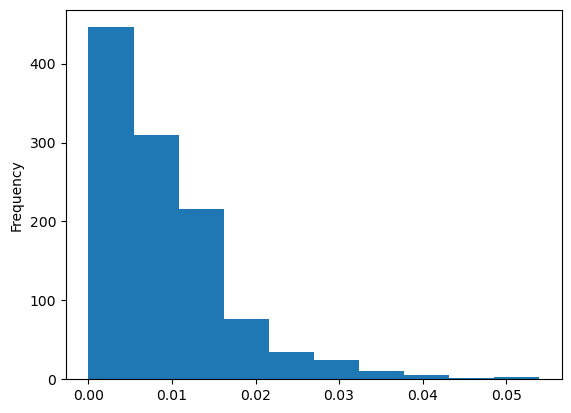

In [ ]:
occurrence_df.norm_occurrences.plot.hist()

<Axes: xlabel='month', ylabel='occurrences'>

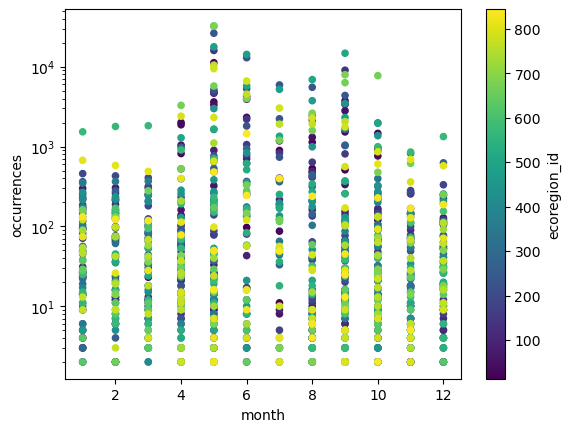

In [ ]:
# Plotting a scatter with regular "occurrences" by month
occurrence_df.reset_index().plot.scatter(
    x='month', y='occurrences', c='ecoregion_id', logy=True
)

<Axes: xlabel='month', ylabel='norm_occurrences'>

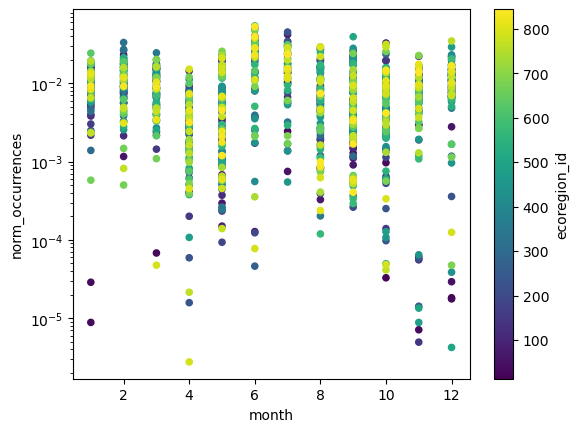

In [ ]:
# Plotting a scatter with normalized occurrences by month
occurrence_df.reset_index().plot.scatter(
    x='month', y='norm_occurrences', c='ecoregion_id', logy=True
)

In [ ]:
# Simplify the geometry to speed up processing
eco_gdf.geometry = eco_gdf.simplify(.1, preserve_topology=False)

# Change the CRS to Mercator for mapping
eco_gdf = eco_gdf.to_crs(ccrs.Mercator())

# Check that the plot runs in a reasonable amount of time
eco_gdf.hvplot(
    geo=True,
    crs=ccrs.Mercator(),
    hover_cols=["ecoregion_id"],
)

NameError: name 'eco_gdf' is not defined

In [ ]:
# Join the occurrences with the plotting GeoDataFrame
occurrence_gdf = eco_gdf.join(occurrence_df[['norm_occurrences']])

# Remove any empty geometry rows. These can cause errors if they persist in the data. 
occurrence_gdf = occurrence_gdf[~occurrence_gdf.geometry.is_empty]

# Get the plot bounds so they don't change with the slider
# xmin, ymin, xmax, ymax = gbif_gdf.to_crs(ccrs.Mercator()).total_bounds

# This code above will plot the entire range of the data (even other continents/unusual sightings)
# I am just interested in the South-North American data, so I set the bounds manually.

xmin = -34821585.49397232
xmax = -2000000.0
ymax = 11000000.0
ymin = -4000000.0

# List month names on the slider
month_widget = pn.widgets.DiscreteSlider(
    options={
        calendar.month_name[month_num]: month_num
        for month_num in range(1,13)
    }
)

# Plot occurrence by ecoregion and month
migration_plot = (
    occurrence_gdf
    .hvplot(
        c='norm_occurrences',
        groupby='month',
        # Use background tiles
        geo=True, crs=ccrs.Mercator(), tiles='CartoLight',
        title="American Redstart Migration, 2024",
        xlim=(xmin, xmax), ylim=(ymin, ymax),
        frame_height=300,
        frame_width=300,
        widgets={'month': month_widget},
        widget_location='bottom'
    )
)

# Save the plot
migration_plot.save('redstart-migration-2024.html', embed=True)
# Display the plot
migration_plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'25623729-efcd-45ee-931c-4809c667004e': {'version…

In [ ]:
occurrence_gdf.to_file("redstart_occurrence_2024.geojson", driver="GeoJSON")

INFO:Created 1,103 records
